## Яндекс.Афиша.Анализ.
Автор: Симуткин М.А.  
Дата: 28.07.25

**Цели и задачи**  

Провести исследовательский анализ данных в Python, чтобы выявить инсайты об изменении пользовательских предпочтений и популярности событий осенью 2024 года, а также проверить гипотезы о разнице в поведении пользователей с мобильными и стационарными устройствами.

**Описание данных**  

включает информацию обо всех заказах билетов, совершённых с двух типов устройств — мобильных и стационарных:
- `order_id` — уникальный идентификатор заказа.
- `user_id` — уникальный идентификатор пользователя.
- `created_dt_msk` — дата создания заказа (московское время).
- `created_ts_msk` — дата и время создания заказа (московское время).
- `event_id` — идентификатор мероприятия из таблицы events.
- `cinema_circuit` — сеть кинотеатров. Если не применимо, то здесь будет значение 'нет'.
- `age_limit` — возрастное ограничение мероприятия.
- `currency_code` — валюта оплаты, например rub для российских рублей.
- `device_type_canonical` — тип устройства, с которого был оформлен заказ, например mobile для мобильных устройств, desktop для стационарных.
- `revenue` — выручка от заказа.
- `service_name` — название билетного оператора.
- `tickets_count` — количество купленных билетов.
- `total` — общая сумма заказа.
В данные также был добавлен столбец days_since_prev с количеством дней с предыдущей покупки для каждого пользователя. Если покупки не было, то данные содержат пропуск.  

содержит информацию о событиях, включая город и регион события, а также информацию о площадке проведения мероприятия. Обратите внимание, что из данных исключили фильмы, ведь, как было видно на дашборде, событий такого типа не так много:
- `event_id` — уникальный идентификатор мероприятия.
- `event_name` — название мероприятия. Аналог поля event_name_code из исходной базы данных.
- `event_type_description` — описание типа мероприятия.
- `event_type_main` — основной тип мероприятия: театральная постановка, концерт и так далее.
- `organizers` — организаторы мероприятия.
- `region_name` — название региона.
- `city_name` — название города.
- `venue_id` — уникальный идентификатор площадки.
- `venue_name` — название площадки.
- `venue_address` — адрес площадки.  

Анализ данных в предыдущей части проекта показал, что выручка от заказов представлена в двух валютах — российских рублях и казахстанских тенге.  
Для удобства решения было бы корректно привести данные к одной валюте, например к российским рублям.  
с информацией о курсе тенге к российскому рублю за 2024 год. Значения в рублях представлено для 100 тенге:
- `nominal` — номинал (100 тенге).
- `data` — дата.
- `curs` — курс тенге к рублю.
- `cdx` — обозначение валюты (kzt).

**Содержание проекта**
1. [Вступление](#Яндекс.Афиша.Анализ.)
2. [Загрузка данных и знакомство с ними](#Загрузка-данных-и-знакомство-с-ними)
3. [Предобработка данных и подготовка их к исследованию](#Предобработка-данных-и-подготовка-их-к-исследованию)
4. [Исследовательский анализ данных](#Исследовательский-анализ-данных)  
    4.1. [Анализ распределения заказов по сегментам и их сезонные изменения](#Анализ-распределения-заказов-по-сегментам-и-их-сезонные-изменения)  
    4.2. [Осенняя активность пользователей](#Осенняя-активность-пользователей)  
    4.3. [Популярные события и партнёры](#Популярные-события-и-партнёры)  
5. [Статистический анализ данных](#Статистический-анализ-данных)
6. [Общий вывод и рекомендации](#Общий-вывод-и-рекомендации)

## Загрузка данных и знакомство с ними
Загрузите данные и получите первую информацию о них. Оцените объём данных, их корректность и соответствие описанию, а также предположите, какие шаги необходимо сделать на стадии предобработки данных. Основные моменты зафиксируйте в промежуточном выводе.

In [1]:
#импорт библиотека
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

In [2]:
#импорт методов из библиотек
from scipy import stats
from scipy.stats import ttest_ind

In [3]:
#загрузка данных
df_order = pd.read_csv('_')
df_event = pd.read_csv('_')
df_tenge = pd.read_csv('_')

In [4]:
#включает информацию обо всех заказах билетов, совершённых с двух типов устройств — мобильных и стационарных
df_order.info()
display(df_order.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   order_id               290849 non-null  int64  
 1   user_id                290849 non-null  object 
 2   created_dt_msk         290849 non-null  object 
 3   created_ts_msk         290849 non-null  object 
 4   event_id               290849 non-null  int64  
 5   cinema_circuit         290849 non-null  object 
 6   age_limit              290849 non-null  int64  
 7   currency_code          290849 non-null  object 
 8   device_type_canonical  290849 non-null  object 
 9   revenue                290849 non-null  float64
 10  service_name           290849 non-null  object 
 11  tickets_count          290849 non-null  int64  
 12  total                  290849 non-null  float64
 13  days_since_prev        268909 non-null  float64
dtypes: float64(3), int64(4), object(7)
m

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0


In [5]:
#содержит информацию о событиях, включая город и регион события, а также информацию о площадке проведения мероприятия
df_event.info()
display(df_event.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22427 entries, 0 to 22426
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   event_id                22427 non-null  int64 
 1   event_name              22427 non-null  object
 2   event_type_description  22427 non-null  object
 3   event_type_main         22427 non-null  object
 4   organizers              22427 non-null  object
 5   region_name             22427 non-null  object
 6   city_name               22427 non-null  object
 7   city_id                 22427 non-null  int64 
 8   venue_id                22427 non-null  int64 
 9   venue_name              22427 non-null  object
 10  venue_address           22427 non-null  object
dtypes: int64(3), object(8)
memory usage: 1.9+ MB


,event_id,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4436,e4f26fba-da77-4c61-928a-6c3e434d793f,спектакль,театр,№4893,Североярская область,Озёрск,2,1600,"Кладбище искусств ""Проблема"" и партнеры","наб. Загородная, д. 785"
1,5785,5cc08a60-fdea-4186-9bb2-bffc3603fb77,спектакль,театр,№1931,Светополянский округ,Глиноград,54,2196,"Лекции по искусству ""Свет"" Групп","ул. Ягодная, д. 942"
2,8817,8e379a89-3a10-4811-ba06-ec22ebebe989,спектакль,театр,№4896,Североярская область,Озёрск,2,4043,"Кинокомитет ""Золотая"" Инк","ш. Коммуны, д. 92 стр. 6"
3,8849,682e3129-6a32-4952-9d8a-ef7f60d4c247,спектакль,театр,№4960,Каменевский регион,Глиногорск,213,1987,"Выставка ремесел ""Свет"" Лтд","пер. Набережный, д. 35"
4,8850,d6e99176-c77f-4af0-9222-07c571f6c624,спектакль,театр,№4770,Лесодальний край,Родниковец,55,4230,"Фестивальный проект ""Листья"" Групп","пер. Проезжий, д. 9"


In [6]:
#с информацией о курсе тенге к российскому рублю за 2024 год
df_tenge.info()
display(df_tenge.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


#### Вывод:
1. df_order — таблица заказов:
    - 290,849 записей, 14 столбцов.
    - Все строки заполнены, кроме столбца days_since_prev, что логично — пропуски там, где нет предыдущей покупки (первая покупка пользователя)
    - Даты и время представлены строками, потребуется преобразование в datetime для анализа по времени.
    - Валюта указана в двух вариантах: rub и kzt — необходимо привести к одной валюте.
2. df_event — таблица событий:
    - 22,427 записей, 11 столбцов.
    - Все поля заполнены.
3. df_tenge — курс тенге к рублю:
    - 357 записей, 4 столбца.
    - Все поля заполнены.
    - Даты в строковом формате, нужно преобразовать в datetime.

## Предобработка данных и подготовка их к исследованию

In [7]:
#объдиняем данные в один датафрейм для удобной работы
df = df_order.merge(df_event, on='event_id', how='left', suffixes=('', '_event'))

In [8]:
#преобразование типов дат
df['created_dt_msk'] = pd.to_datetime(df['created_dt_msk'])
df['created_ts_msk'] = pd.to_datetime(df['created_ts_msk'])
df_tenge['data'] = pd.to_datetime(df_tenge['data'])

In [9]:
#анализ категориальных столбцов в df_order
display(df['currency_code'].value_counts())
display(df['device_type_canonical'].value_counts())
display(df['cinema_circuit'].value_counts())
display(df['service_name'].value_counts())

rub    285780
kzt      5069
Name: currency_code, dtype: int64

mobile     232679
desktop     58170
Name: device_type_canonical, dtype: int64

нет           289451
Другое          1261
КиноСити         122
Киномакс           7
Москино            7
ЦентрФильм         1
Name: cinema_circuit, dtype: int64

Билеты без проблем        63709
Лови билет!               41126
Билеты в руки             40364
Мой билет                 34843
Облачко                   26642
Лучшие билеты             17795
Весь в билетах            16849
Прачечная                 10273
Край билетов               6207
Тебе билет!                5228
Яблоко                     5039
Дом культуры               4502
За билетом!                2865
Городской дом культуры     2733
Show_ticket                2200
Мир касс                   2167
Быстробилет                2003
Выступления.ру             1616
Восьмёрка                  1118
Crazy ticket!               790
Росбилет                    539
Шоу начинается!             499
Быстрый кассир              381
Радио ticket                376
Телебилет                   321
КарандашРУ                  133
Реестр                      125
Билет по телефону            85
Вперёд!                      80
Дырокол                      74
Кино билет                   67
Цвет и б

In [49]:
#анализ распределения revenue и tickets_count по валютам
display(df.groupby('currency_code')['revenue'].describe()) #сделай потом график распределенич, проверь правильно ли прочитал цифры на график

,count,mean,std,min,25%,50%,75%,max
currency_code,,,,,,,,
kzt,5069.0,4995.206767,4916.752776,0.00,518.1000,3698.83,7397.66,26425.86
rub,285780.0,547.568333,871.524559,-90.76,113.8275,346.10,791.70,81174.54


In [11]:
display(df.groupby('currency_code')['tickets_count'].describe())

,count,mean,std,min,25%,50%,75%,max
currency_code,,,,,,,,
kzt,5069.0,2.762872,1.115558,1.0,2.0,3.0,4.0,6.0
rub,285780.0,2.754077,1.171419,1.0,2.0,3.0,4.0,57.0


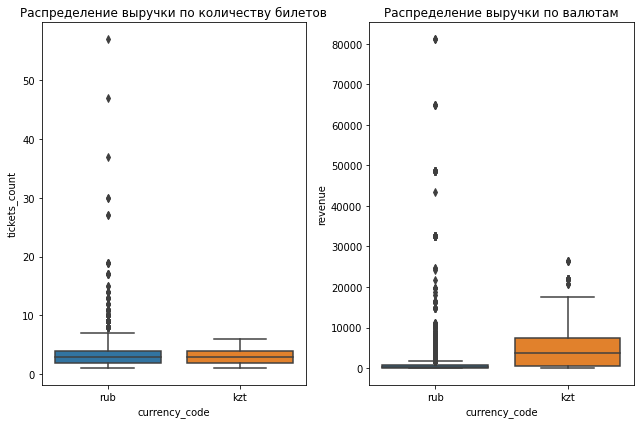

In [12]:
#визуализация распределения
fig, axes = plt.subplots(1, 2, figsize=(9, 6))

#визуализация распределения tickets_count
sns.boxplot(x='currency_code', y='tickets_count', data=df, ax=axes[0])
axes[0].set_title('Распределение выручки по количеству билетов')

#визуализация распределения revenue
sns.boxplot(x='currency_code', y='revenue', data=df, ax=axes[1])
axes[1].set_title('Распределение выручки по валютам')

plt.tight_layout()
plt.show()

#### Вывод:
 - В данных выбросы

In [13]:
#отбор данных по 99-му процентилю выручки для каждой валюты отдельно
percentile_99_rub = df.loc[df_order['currency_code']=='rub', 'revenue'].quantile(0.99)
percentile_99_kzt = df.loc[df_order['currency_code']=='kzt', 'revenue'].quantile(0.99)
display(f'99-й перцентиль revenue в рублях: {percentile_99_rub:.2f}')
display(f'99-й перцентиль revenue в тенге: {percentile_99_kzt:.2f}')


'99-й перцентиль revenue в рублях: 2569.59'

'99-й перцентиль revenue в тенге: 17617.24'

In [14]:
#фильтрация по 99-му перцентилю, так как найдены выбросы
df_filter = df[
    ((df['currency_code']=='rub') & (df['revenue'] <= percentile_99_rub)) |
    ((df['currency_code']=='kzt') & (df['revenue'] <= percentile_99_kzt))
].copy()

display(f'Количество записей после фильтрации выбросов: {len(df_filter)}')

'Количество записей после фильтрации выбросов: 287962'

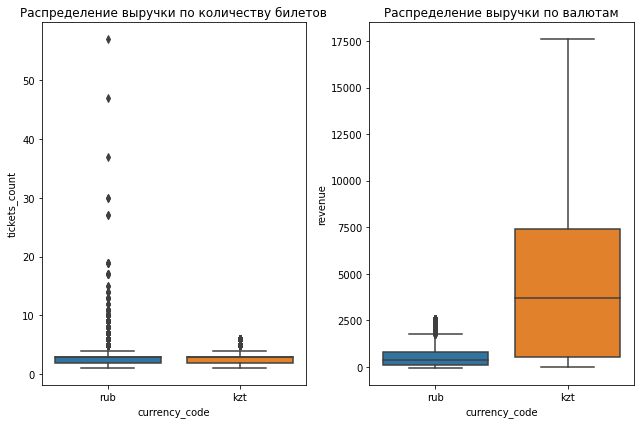

In [15]:
#визуализация распределения
fig, axes = plt.subplots(1, 2, figsize=(9, 6))

#визуализация распределения tickets_count
sns.boxplot(x='currency_code', y='tickets_count', data=df_filter, ax=axes[0])
axes[0].set_title('Распределение выручки по количеству билетов')

#визуализация распределения revenue
sns.boxplot(x='currency_code', y='revenue', data=df_filter, ax=axes[1])
axes[1].set_title('Распределение выручки по валютам')

plt.tight_layout()
plt.show()

In [16]:
#проверка дубликатов
display('Явные дубликаты в df_order:', df_filter.duplicated().sum())

'Явные дубликаты в df_order:'

0

In [17]:
#проверка неявных дубликатов по user_id, event_id, created_ts_msk, tickets_count, total (без order_id)
duplicates_subset = df_filter.duplicated(subset=['user_id', 'event_id', 'created_ts_msk', 'tickets_count', 'total'])
display('Неявные дубликаты (без order_id):', duplicates_subset.sum())

'Неявные дубликаты (без order_id):'

43

#### Вывод:
 - Найдены неявные дубликаты в количестве 43 штук, удалим их без рисков для анализа, из за малого количества

In [18]:
#удаление неявных дубликатов
df_filter = df_filter[~duplicates_subset].copy()

In [19]:
#создадим словарь курсов по дате
df_tenge.set_index('data', inplace=True)
df_tenge['rate'] = df_tenge['curs'] / df_tenge['nominal']

#добавим в df_order_filtered курс для даты заказа
df_filter['rate'] = df_filter['created_dt_msk'].map(df_tenge['rate'])

#для рублевых заказов курс = 1
df_filter.loc[df_filter['currency_code']=='rub', 'rate'] = 1

In [20]:
#проверяем результат
df_filter.head(5)

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address,rate
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,...,спектакль,театр,№3322,Каменевский регион,Глиногорск,213.0,3972.0,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",1.0
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,...,событие,выставки,№4850,Каменевский регион,Глиногорск,213.0,2941.0,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4",1.0
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,...,цирковое шоу,другое,№1540,Каменевский регион,Глиногорск,213.0,4507.0,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6",1.0
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,...,выставка,другое,№5049,Североярская область,Озёрск,2.0,3574.0,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8",1.0
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,...,шоу,стендап,№832,Озернинский край,Родниковецк,240.0,1896.0,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8",1.0


In [21]:
#пропуски в rate (если есть даты вне диапазона)
missing_rates = df_filter['rate'].isna().sum()
display(f'Пропущенные значения курса: {missing_rates}')

'Пропущенные значения курса: 0'

In [22]:
#рассчитаем revenue_rub и one_ticket_revenue_rub
df_filter['revenue_rub'] = df_filter['revenue'] * df_filter['rate']
df_filter['one_ticket_revenue_rub'] = df_filter['revenue_rub'] / df_filter['tickets_count']

In [23]:
#проверяем результат
df_filter.head(5)

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address,rate,revenue_rub,one_ticket_revenue_rub
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,...,№3322,Каменевский регион,Глиногорск,213.0,3972.0,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",1.0,1521.94,380.4850
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,...,№4850,Каменевский регион,Глиногорск,213.0,2941.0,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4",1.0,289.45,144.7250
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,...,№1540,Каменевский регион,Глиногорск,213.0,4507.0,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6",1.0,1258.57,314.6425
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,...,№5049,Североярская область,Озёрск,2.0,3574.0,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8",1.0,8.49,4.2450
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,...,№832,Озернинский край,Родниковецк,240.0,1896.0,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8",1.0,1390.41,463.4700


In [24]:
#создание нового признака month
df_filter['month'] = df_filter['created_dt_msk'].dt.month

In [25]:
#создание нового признака season
def get_season(month):
    if month in [12, 1, 2]:
        return 'зима'
    elif month in [3,4,5]:
        return 'весна'
    elif month in [6,7,8]:
        return 'лето'
    else:
        return 'осень'

df_filter['season'] = df_filter['month'].apply(get_season)

#### Вывод:
 - `revenue` привиден к рублевой валюте, теперь ориентируемся на столбец `revenue_rub`
 - `one_ticket_revenue_rub` - цена за один билет в рублях
 - созданы новые временные признаки - `month` и `season`

In [26]:
#результат
df_filter.info()
df_filter.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 287919 entries, 0 to 290848
Data columns (total 29 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                287919 non-null  int64         
 1   user_id                 287919 non-null  object        
 2   created_dt_msk          287919 non-null  datetime64[ns]
 3   created_ts_msk          287919 non-null  datetime64[ns]
 4   event_id                287919 non-null  int64         
 5   cinema_circuit          287919 non-null  object        
 6   age_limit               287919 non-null  int64         
 7   currency_code           287919 non-null  object        
 8   device_type_canonical   287919 non-null  object        
 9   revenue                 287919 non-null  float64       
 10  service_name            287919 non-null  object        
 11  tickets_count           287919 non-null  int64         
 12  total                   287919

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,city_name,city_id,venue_id,venue_name,venue_address,rate,revenue_rub,one_ticket_revenue_rub,month,season
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,...,Глиногорск,213.0,3972.0,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",1.0,1521.94,380.4850,8,лето
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,...,Глиногорск,213.0,2941.0,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4",1.0,289.45,144.7250,7,лето
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,...,Глиногорск,213.0,4507.0,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6",1.0,1258.57,314.6425,10,осень
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,...,Озёрск,2.0,3574.0,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8",1.0,8.49,4.2450,7,лето
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,...,Родниковецк,240.0,1896.0,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8",1.0,1390.41,463.4700,10,осень


In [27]:
#оптимизация финального датафрейма
#удалим строки с пропусками в event-данных, очень малое количество
df_filter = df_filter.dropna(subset=['event_name', 
                       'event_type_description', 
                       'event_type_main', 
                       'organizers', 
                       'region_name', 
                       'city_name', 
                       'city_id', 
                       'venue_id', 
                       'venue_name', 
                       'venue_address'])

#приведём city_id и venue_id к int, т.к. это индификаторы 
df_filter['city_id'] = df_filter['city_id'].astype(int)
df_filter['venue_id'] = df_filter['venue_id'].astype(int)

#приводи столбцы с категориями к типу данных category
cols_to_cat = [
    'event_type_description',
    'event_type_main',
    'device_type_canonical',
    'currency_code',
    'cinema_circuit'
]

for col in cols_to_cat:
    df_filter[col] = df_filter[col].astype('category')
    
#оптимизируем int данные
int64_cols = df_filter.select_dtypes(include=['int64']).columns

for col in int64_cols:
    df_filter[col] = df_filter[col].astype('int32')

#оптимизируем float данные
float64_cols = df_filter.select_dtypes(include=['float64']).columns

for col in float64_cols:
    df_filter[col] = df_filter[col].astype('float32')

In [28]:
#проверяем
df_filter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 287681 entries, 0 to 290848
Data columns (total 29 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                287681 non-null  int32         
 1   user_id                 287681 non-null  object        
 2   created_dt_msk          287681 non-null  datetime64[ns]
 3   created_ts_msk          287681 non-null  datetime64[ns]
 4   event_id                287681 non-null  int32         
 5   cinema_circuit          287681 non-null  category      
 6   age_limit               287681 non-null  int32         
 7   currency_code           287681 non-null  category      
 8   device_type_canonical   287681 non-null  category      
 9   revenue                 287681 non-null  float32       
 10  service_name            287681 non-null  object        
 11  tickets_count           287681 non-null  int32         
 12  total                   287681

In [29]:
size_df = df.memory_usage(deep=True).sum()
size_df_filter = df_filter.memory_usage(deep=True).sum()

display(f'Размер df: {size_df / 1024**2:.2f} МБ')
display(f'Размер df_filter: {size_df_filter / 1024**2:.2f} МБ')

reduction = (size_df - size_df_filter) / size_df * 100
display(f'Сокращение размера: {reduction:.2f}%')

'Размер df: 405.39 МБ'

'Размер df_filter: 293.10 МБ'

'Сокращение размера: 27.70%'

#### Вывод:
 - в данных обнаружены выбросы, которые были отфильтрованны по 99% перцентилю.
 - найдены неявные дубликаты в количестве `43` штук, удалим их без рисков для анализа, из за малого количества
 - удалены строки с пропусками в данных о событиях (очень малое количество)
 - `revenue` привиден к рублевой валюте, теперь ориентируемся на столбец `revenue_rub`
 - `one_ticket_revenue_rub` - цена за один билет в рублях
 - созданы новые временные признаки - `month` и `season` 
 - столбцы привиденны к корректному типу данных
 - оптимизация дф сократила размер на `27.70%`

## Исследовательский анализ данных  

### Анализ распределения заказов по сегментам и их сезонные изменения  
Анализ дашборда показал, что в данных наблюдается сезонность — осенью количество заказов увеличивается.  
На стадии исследовательского анализа изучите изменение пользовательской активности или пользовательского интереса в связи с сезонностью. 
Анализируйте динамику по таким разрезам:  
тип мероприятия event_type_main;  
тип устройства device_type_canonical;  
категория мероприятий по возрастному рейтингу age_limit.  

В этом разделе изучите распределение заказов по сегментам и их сезонные изменения, выполнив следующие шаги:  
Для каждого месяца найдите количество заказов и визуализируйте результаты.  
Проверьте, фиксируется ли увеличение заказов от июня к ноябрю 2024 года.  

Для осеннего и летнего периодов сравните распределение заказов билетов по разным категориям: тип мероприятия, тип устройства, категория мероприятия по возрастному рейтингу. 
Результаты визуализируйте подходящим графиком, который поможет сопоставить значения для летнего и осеннего сезонов. 

Рекомендация: поскольку абсолютное количество заказов в разные сезоны может меняться, при сопоставлении результатов для каждого сегмента используйте доли.  

Изучите изменение выручки с продажи одного билета в зависимости от типа мероприятия летом и осенью.  
Видна ли динамика средней стоимости билета в разрезе разных категорий мероприятий?  
Для каждого типа мероприятия рассчитайте среднее значение выручки с одного билета, затем найдите относительное изменение осенних значений по сравнению с летними. 
Результат сопроводите подходящей визуализацией.  

Сделайте вывод о том, как меняется распределение заказов в каждой категории с наступлением осени.  
Было ли изменение средней стоимости одного билета в разрезе разных типов мероприятий?  

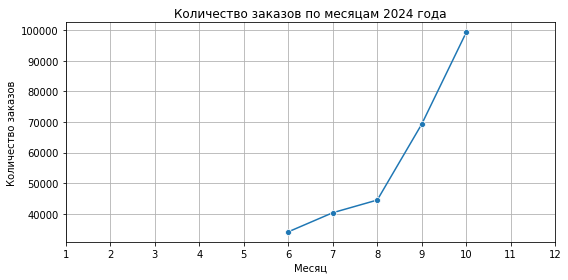

In [30]:
#группируем по месяцу и считаем количество заказов
orders_per_month = df_filter.groupby('month').size().reset_index(name='orders_count')

#визуализация
plt.figure(figsize=(8,4))

sns.lineplot(data=orders_per_month, x='month', y='orders_count', marker='o')

plt.title('Количество заказов по месяцам 2024 года')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')

plt.xticks(range(1,13))
plt.grid(True)

plt.tight_layout()
plt.show()

#### Вывод:
 - Осенью наблюдается резкий рост количества заказов

In [31]:
#сегменты сезонов
summer_months = [6,7,8]
autumn_months = [9,10,11]

df_summer = df_filter[df_filter['month'].isin(summer_months)].copy()
df_autumn = df_filter[df_filter['month'].isin(autumn_months)].copy()

def get_segment_shares(df, segment_col):
    counts = df.groupby(segment_col).size()
    shares = counts / counts.sum()
    return shares.reset_index(name='share')

#тип мероприятия
summer_event_type = get_segment_shares(df_summer, 'event_type_main')
autumn_event_type = get_segment_shares(df_autumn, 'event_type_main')

#тип устройства
summer_device_type = get_segment_shares(df_summer, 'device_type_canonical')
autumn_device_type = get_segment_shares(df_autumn, 'device_type_canonical')

#возрастное ограничение
summer_age_limit = get_segment_shares(df_summer, 'age_limit')
autumn_age_limit = get_segment_shares(df_autumn, 'age_limit')

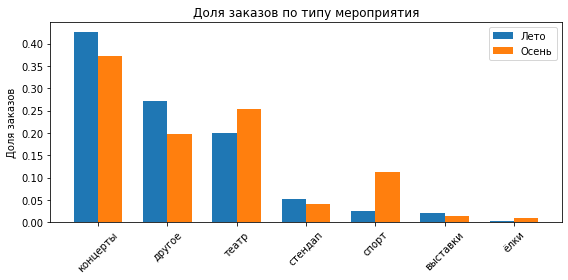

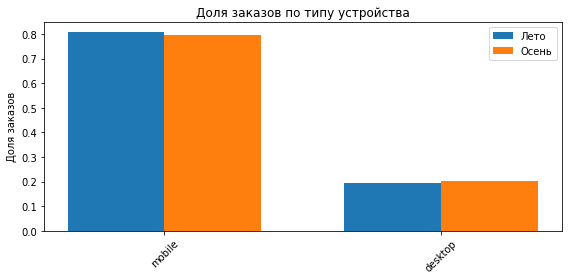

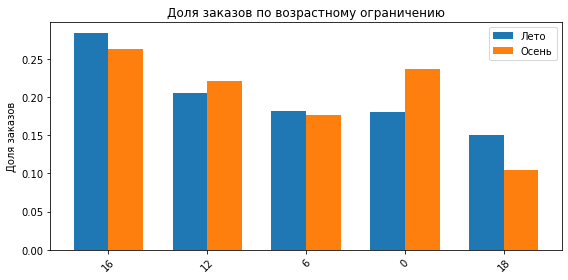

In [32]:
#визуализация
def plot_segment_comparison(summer_df, autumn_df, segment_col, title):
    merged = summer_df.merge(autumn_df, on=segment_col, suffixes=('_summer', '_autumn'))
    merged = merged.sort_values(by='share_summer', ascending=False)

    x = range(len(merged))
    width = 0.35

    plt.figure(figsize=(8,4))
    plt.bar(x, merged['share_summer'], width=width, label='Лето')
    plt.bar([i + width for i in x], merged['share_autumn'], width=width, label='Осень')

    plt.xticks([i + width/2 for i in x], merged[segment_col], rotation=45)
    plt.ylabel('Доля заказов')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_segment_comparison(summer_event_type, autumn_event_type, 'event_type_main', 'Доля заказов по типу мероприятия')
plot_segment_comparison(summer_device_type, autumn_device_type, 'device_type_canonical', 'Доля заказов по типу устройства')
plot_segment_comparison(summer_age_limit, autumn_age_limit, 'age_limit', 'Доля заказов по возрастному ограничению')

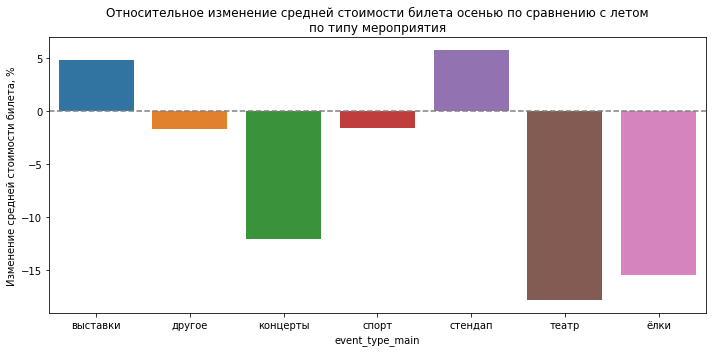

,event_type_main,mean_revenue_summer,mean_revenue_autumn,revenue_change_%
0,выставки,86.416199,90.603607,4.845629
1,другое,77.439796,76.115334,-1.710313
2,концерты,304.712219,268.085968,-12.019949
3,спорт,50.761829,49.970894,-1.558130
4,стендап,218.518112,231.124969,5.769250
5,театр,214.126328,175.977081,-17.816235
6,ёлки,271.436188,229.585587,-15.418211


In [33]:
def mean_ticket_revenue_by_season(df, months, season_name):
    df_season = df[df['month'].isin(months)]
    mean_revenue = df_season.groupby('event_type_main')['one_ticket_revenue_rub'].mean().reset_index()
    mean_revenue.rename(columns={'one_ticket_revenue_rub': f'mean_revenue_{season_name}'}, inplace=True)
    return mean_revenue

mean_revenue_summer = mean_ticket_revenue_by_season(df_filter, summer_months, 'summer')
mean_revenue_autumn = mean_ticket_revenue_by_season(df_filter, autumn_months, 'autumn')

#объединяем для сравнения
revenue_comparison = mean_revenue_summer.merge(mean_revenue_autumn, on='event_type_main')

#рассчитываем относительное изменение (%)
revenue_comparison['revenue_change_%'] = (
    (revenue_comparison['mean_revenue_autumn'] - revenue_comparison['mean_revenue_summer']) /
    revenue_comparison['mean_revenue_summer'] * 100
)

#визуализация
plt.figure(figsize=(10,5))

sns.barplot(data=revenue_comparison.sort_values('revenue_change_%'), x='event_type_main', y='revenue_change_%')

plt.xticks(rotation=0)
plt.ylabel('Изменение средней стоимости билета, %')
plt.title('Относительное изменение средней стоимости билета осенью по сравнению с летом\nпо типу мероприятия')

plt.axhline(0, color='gray', linestyle='--')

plt.tight_layout()
plt.show()

#для наглядности выводим таблицу
display(revenue_comparison)

#### Вывод:
 - осенью доля мероприятий заметно вырастает, только среди спортивных событий
 - осенью повышается популярность мероприятий с возрастным ограничением `0`
 - по типу устройств сезонная динамика минимальна
 - cредняя стоимость билета снижается по большинству типов мероприятий, кроме выставок и стендапа.

### Осенняя активность пользователей  
Изучите активность пользователей осенью 2024 года.  
В вашем распоряжении данные за два осенних месяца.  

Используйте только эти данные и сделайте следующее:  
Проанализируйте динамику изменений по дням для:  
общего числа заказов;  
количества активных пользователей DAU;  
среднего числа заказов на одного пользователя;  
средней стоимости одного билета.  

Рекомендация: удобно создать одну сводную таблицу, и в ней по дням рассчитать число заказов и число уникальных пользователей, а затем найти величину — количество заказов на одного пользователя.  

Полученные результаты можно визуализировать с помощью линейного графика.  
Подобные графики вы строили на дашборде, только делали это с агрегацией по неделям.  
Изучите недельную цикличность. Выделите день недели и сравните пользовательскую активность в будни и выходные.  
Напишите промежуточный вывод о пользовательской активности и недельной цикличности.  

In [34]:
autumn_months = [10, 11]  # два осенних месяца, например октябрь и ноябрь

df_autumn = df_filter[df_filter['month'].isin(autumn_months)].copy()

In [35]:
#группируем по дате
daily_stats = df_autumn.groupby('created_dt_msk').agg(
    orders_count=('order_id', 'count'),
    dau=('user_id', 'nunique'),
    avg_ticket_revenue=('one_ticket_revenue_rub', 'mean')
).reset_index()

#среднее число заказов на одного пользователя
daily_stats['orders_per_user'] = daily_stats['orders_count'] / daily_stats['dau']

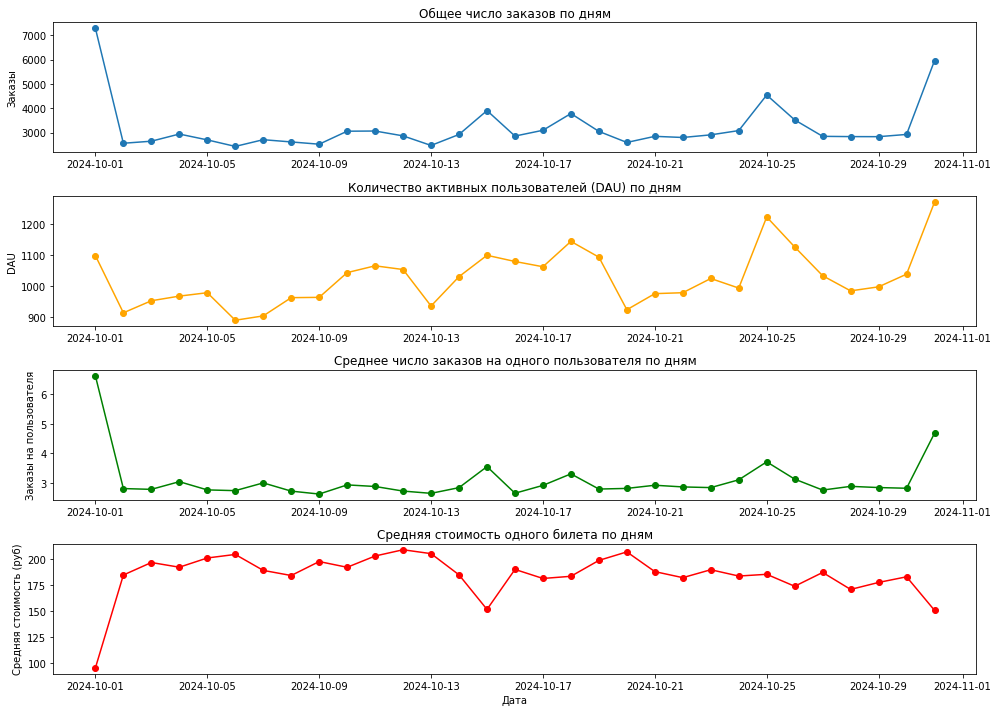

In [36]:
plt.figure(figsize=(14,10))

plt.subplot(4,1,1)
plt.plot(daily_stats['created_dt_msk'], daily_stats['orders_count'], marker='o')
plt.title('Общее число заказов по дням')
plt.ylabel('Заказы')

plt.subplot(4,1,2)
plt.plot(daily_stats['created_dt_msk'], daily_stats['dau'], marker='o', color='orange')
plt.title('Количество активных пользователей (DAU) по дням')
plt.ylabel('DAU')

plt.subplot(4,1,3)
plt.plot(daily_stats['created_dt_msk'], daily_stats['orders_per_user'], marker='o', color='green')
plt.title('Среднее число заказов на одного пользователя по дням')
plt.ylabel('Заказы на пользователя')

plt.subplot(4,1,4)
plt.plot(daily_stats['created_dt_msk'], daily_stats['avg_ticket_revenue'], marker='o', color='red')
plt.title('Средняя стоимость одного билета по дням')
plt.ylabel('Средняя стоимость (руб)')
plt.xlabel('Дата')

plt.tight_layout()
plt.show()

#### Вывод:
 - Меньше средняя цена билета = больше заказов => больше выручка.

In [37]:
#день недели (0 - понедельник/6 - воскресенье)
daily_stats['weekday'] = daily_stats['created_dt_msk'].dt.dayofweek
#метка выходного дня
daily_stats['is_weekend'] = daily_stats['weekday'] >= 5  # суббота и воскресенье

#группируем по выходным и будням, считаем среднее по ключевым метрикам
weekly_cycle = daily_stats.groupby('is_weekend').agg(
    avg_orders=('orders_count', 'mean'),
    avg_dau=('dau', 'mean'),
    avg_orders_per_user=('orders_per_user', 'mean'),
    avg_ticket_revenue=('avg_ticket_revenue', 'mean')
).reset_index()

weekly_cycle['day_type'] = weekly_cycle['is_weekend'].map({False: 'Будни', True: 'Выходные'})

display(weekly_cycle[['day_type', 'avg_orders', 'avg_dau', 'avg_orders_per_user', 'avg_ticket_revenue']])

,day_type,avg_orders,avg_dau,avg_orders_per_user,avg_ticket_revenue
0,Будни,3337.086957,1034.173913,3.187939,179.705643
1,Выходные,2813.000000,1004.750000,2.793236,198.106262


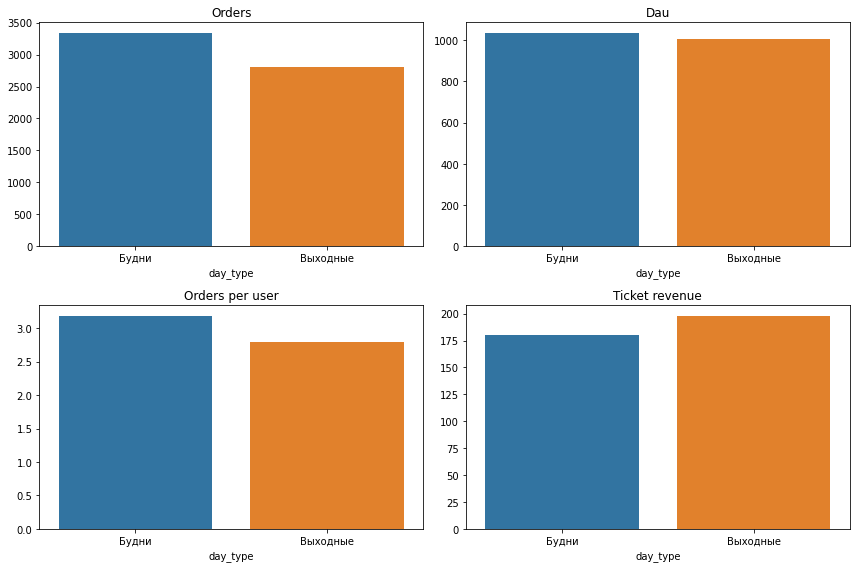

In [38]:
#визуализация
metrics = ['avg_orders', 'avg_dau', 'avg_orders_per_user', 'avg_ticket_revenue']

plt.figure(figsize=(12,8))
for i, metric in enumerate(metrics, 1):
    plt.subplot(2,2,i)
    sns.barplot(x='day_type', y=metric, data=weekly_cycle)
    plt.title(metric.replace('avg_', '').replace('_', ' ').capitalize())
    plt.ylabel('')
plt.tight_layout()
plt.show()

#### Вывод:
 - средняя цена билета в выходные выше, чем в будни.
 - в будние дни выше количество заказов и активных пользователей, чем в выходные.
 

### Популярные события и партнёры  
После того как изучите изменение популярности событий и пользовательской активности осенью 2024 года, посмотрите, как события распределены по регионам и партнёрам.  
Это позволит выделить ключевые регионы и партнёров, которые вносят наибольший вклад в выручку.  
Для каждого региона посчитайте уникальное количество мероприятий и общее число заказов.  

В каких регионах предлагается наибольшее разнообразие мероприятий?  

Для каждого билетного партнёра посчитайте общее число уникальных мероприятий, обработанных заказов и суммарную выручку с заказов билетов.  
Сделайте акцент на наиболее активных партнёрах.  
Рекомендация: исследуйте не только абсолютные значения, но и доли.  
Например, для каждого региона посчитайте долю проводимых мероприятий от их общего числа или долю заказов в регионе от общего числа заказов.  

В конце напишите промежуточный вывод, проанализируйте не только топ-категории, но и общее распределение данных между категориями.  
Существуют ли явные лидеры среди регионов и партнёров?  

In [39]:
#уникальное количество мероприятий по регионам
region_events = df_autumn.groupby('region_name')['event_id'].nunique().reset_index(name='unique_events')

#общее число заказов по регионам
region_orders = df_autumn.groupby('region_name')['order_id'].count().reset_index(name='total_orders')

#объединяем
region_stats = region_events.merge(region_orders, on='region_name')

#доли
total_events = region_stats['unique_events'].sum()
total_orders = region_stats['total_orders'].sum()

region_stats['events_share'] = region_stats['unique_events'] / total_events
region_stats['orders_share'] = region_stats['total_orders'] / total_orders

region_stats = region_stats.sort_values(by='unique_events', ascending=False)

display(region_stats)

,region_name,unique_events,total_orders,events_share,orders_share
22,Каменевский регион,2899,28891,0.247397,0.291073
58,Североярская область,1974,12551,0.168459,0.126450
55,Светополянский округ,566,2992,0.048302,0.030144
74,Широковская область,537,4475,0.045827,0.045085
50,Речиновская область,411,2104,0.035074,0.021197
...,...,...,...,...,...
77,Яснопольский округ,2,3,0.000171,0.000030
46,Островогорский округ,2,13,0.000171,0.000131
29,Кристальная область,2,3,0.000171,0.000030
54,Светолесский край,2,6,0.000171,0.000060


#### Вывод:
 - Каменевский регион лидирует по количеству уникальных мероприятий и заказов (около 25–27%).
 - Североярская и Широковская области занимают второе и третье места по активности.
 - остальные регионы значительно уступают по объёмам.

In [40]:
#популярные организаторы(партнеры)
partner_stats = df_autumn.groupby('organizers').agg(
    unique_events=('event_id', 'nunique'),
    total_orders=('order_id', 'count'),
    total_revenue=('one_ticket_revenue_rub', 'sum')
).reset_index()

#cчитаем доли
total_unique_events = partner_stats['unique_events'].sum()
total_orders = partner_stats['total_orders'].sum()
total_revenue = partner_stats['total_revenue'].sum()

partner_stats['events_share'] = partner_stats['unique_events'] / total_unique_events
partner_stats['orders_share'] = partner_stats['total_orders'] / total_orders
partner_stats['revenue_share'] = partner_stats['total_revenue'] / total_revenue

#cортируем по суммарной выручке, чтобы выделить ключевых партнёров
partner_stats = partner_stats.sort_values(by='total_revenue', ascending=False)

display("Статистика по партнёрам:")
display(partner_stats)

'Статистика по партнёрам:'

,organizers,unique_events,total_orders,total_revenue,events_share,orders_share,revenue_share
782,№2121,43,3951,661109.937500,0.003670,0.039806,3.725934e-02
2897,№894,14,1253,329432.656250,0.001195,0.012624,1.856642e-02
15,№1022,6,546,246841.000000,0.000512,0.005501,1.391165e-02
2327,№4403,27,702,241025.890625,0.002304,0.007073,1.358392e-02
2098,№4054,7,664,203791.781250,0.000597,0.006690,1.148545e-02
...,...,...,...,...,...,...,...
1021,№2490,3,5,0.000000,0.000256,0.000050,0.000000e+00
2248,№4299,1,61,0.000000,0.000085,0.000615,0.000000e+00
496,№1749,2,3,0.000000,0.000171,0.000030,0.000000e+00
1806,№3648,1,1,-1.030000,0.000085,0.000010,-5.804953e-08


#### Вывод:
 - Несколько партнёров (например, №2121) обеспечивают основную часть выручки и заказов.
 - Распределение активности и доходов среди партнёров неравномерное.
 - Большинство партнёров имеют низкие показатели.

## Статистический анализ данных  
Коллеги из продуктового отдела хотят отдельно проверить несколько гипотез относительно активности пользователей мобильных и стационарных устройств.  

Проверьте две гипотезы, которые предполагают большую активность пользователей мобильных устройств:   
Среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств.  
Среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств.  

Перед проведением гипотез изучите сравниваемые данные, обоснуйте выбор статистического теста, укажите формулировку нулевой и альтернативной гипотез.  
Результаты тестов прокомментируйте в промежуточном выводе.  
Используйте данные только за осенний период.

#### Гипотеза 1: Среднее количество заказов на пользователя

**Нулевая гипотеза (H0):**  
Среднее количество заказов на одного пользователя мобильного приложения равно среднему количеству заказов у пользователей стационарных устройств.  
**Альтернативная гипотеза (H1):**  
Среднее количество заказов на одного пользователя мобильного приложения выше, чем у пользователей стационарных устройств.

In [41]:
#фильтр по осени
autumn_months = [9, 10, 11]
df_autumn = df_filter[df_filter['month'].isin(autumn_months)].copy()

#группировка по user_id и device_type_canonical — считаем количество заказов на пользователя
user_order_counts = df_autumn.groupby(['user_id', 'device_type_canonical']).size().reset_index(name='orders_per_user')

#разделяем данные по типу устройства
mobile_users = user_order_counts[user_order_counts['device_type_canonical'] == 'mobile']['orders_per_user']
desktop_users = user_order_counts[user_order_counts['device_type_canonical'] == 'desktop']['orders_per_user']

In [42]:
display("Мобильные пользователи:")
display(f"Количество уникальных пользователей: {len(mobile_users)}")
display(f"Среднее количество заказов на пользователя: {mobile_users.mean():.3f}")
display(f"Стандартное отклонение: {mobile_users.std():.3f}")

display("\nПользователи стационарных устройств:")
display(f"Количество уникальных пользователей: {len(desktop_users)}")
display(f"Среднее количество заказов на пользователя: {desktop_users.mean():.3f}")
display(f"Стандартное отклонение: {desktop_users.std():.3f}")

'Мобильные пользователи:'

'Количество уникальных пользователей: 15808'

'Среднее количество заказов на пользователя: 8.494'

'Стандартное отклонение: 64.514'

'\nПользователи стационарных устройств:'

'Количество уникальных пользователей: 15808'

'Среднее количество заказов на пользователя: 2.170'

'Стандартное отклонение: 20.232'

#### Вывод:
 - Высокое стандартное отклонение по сравнению со средним (особенно у мобильных пользователей: 64.5 - 8.5) указывает на сильную скошенность распределения — вероятно, большинство пользователей сделали 1–2 заказа, но есть небольшая группа с сотнями заказов 

Обоснование выбора статистического теста:
 - Выборки: независимые (пользователи используют только один тип устройства).
 - Размер выборок: одинаковый и достаточно большой (n = 15 808 в каждой), что позволяет применять t-тест благодаря центральной предельной теореме, даже при не нормальном распределении.
 - Дисперсии: сильно различаются, поэтому предположение о равенстве дисперсий нарушено.
 - Тип теста: односторонний, так как нас интересует превосходство мобильных пользователей.  
 

**Выбор: t-тест Уэлча (Welch’s t-test) для независимых выборок с неравными дисперсиями.**

In [43]:
#проведём t-тест Уэлча (односторонний)
alpha = 0.05 #уровень значимости
power = 0.8 #вероятность что нужные мне изменнения найдутся
beta = 1-power #вероятность пропустить нужные мне изменения
p1 = 0.3 #конверсия группы теста `mobile_users`
mde = 0.03 #процент изменений, который мы хотит увидеть
p2 = p1 + mde #конверсия для целевой группы `desktop_users`


t_stat, p_val = ttest_ind(mobile_users, desktop_users, equal_var=False, alternative='greater')

display(f"t-статистика: {t_stat:.4f}")
display(f"p-value: {p_val:.10f}")

if p_val < alpha:
    display("Результат: Отклоняем нулевую гипотезу (H0).")
    display("Вывод: Среднее количество заказов на пользователя мобильного приложения статистически значимо выше, чем у пользователей стационарных устройств.")
else:
    display("Результат: Не отклоняем нулевую гипотезу (H0).")
    display("Вывод: Нет достаточных оснований утверждать, что мобильные пользователи делают больше заказов.")

't-статистика: 11.7610'

'p-value: 0.0000000000'

'Результат: Отклоняем нулевую гипотезу (H0).'

'Вывод: Среднее количество заказов на пользователя мобильного приложения статистически значимо выше, чем у пользователей стационарных устройств.'

#### Вывод: 
 - Это различие не является случайным и подтверждается с высокой степенью достоверности.  
Мобильные пользователи не только более многочисленны, но и существенно активнее в пересчёте на одного пользователя.

#### Гипотеза 2: Среднее время между заказами

Для каждого пользователя вычислим среднее время между заказами (в днях). Для пользователей с одним заказом время между заказами определить нельзя — таких пользователей исключим из анализа.

**Нулевая гипотеза (H0):**  
Среднее время между заказами у пользователей мобильных устройств равно времени у пользователей стационарных устройств.  
**Альтернативная гипотеза (H1):**  
Среднее время между заказами у пользователей мобильных устройств выше, чем у пользователей стационарных устройств.

In [44]:
#фильтр по осени: сентябрь, октябрь, ноябрь
autumn_months = [9, 10, 11]
df_autumn = df_filter[df_filter['month'].isin(autumn_months)].copy()

#мы уже удалили пропуски ранее, оставим только тех, у кого days_since_prev не NaN
valid_interval_data = df_autumn.dropna(subset=['days_since_prev']).copy()

#группируем по user_id и device_type_canonical, считаем среднее время между заказами на пользователя
user_interval_mean = valid_interval_data.groupby(['user_id', 'device_type_canonical'])['days_since_prev'].mean().reset_index()

#разделяем выборки по типу устройства
mobile_intervals = user_interval_mean[user_interval_mean['device_type_canonical'] == 'mobile']['days_since_prev']
desktop_intervals = user_interval_mean[user_interval_mean['device_type_canonical'] == 'desktop']['days_since_prev']

In [45]:
#выводим описательную статистику
display("Мобильные пользователи:")
display(f"Количество пользователей: {len(mobile_intervals)}")
display(f"Среднее время между заказами: {mobile_intervals.mean():.3f} дней")
display(f"Стандартное отклонение: {mobile_intervals.std():.3f}")

display("\nПользователи стационарных устройств:")
display(f"Количество пользователей: {len(desktop_intervals)}")
display(f"Среднее время между заказами: {desktop_intervals.mean():.3f} дней")
display(f"Стандартное отклонение: {desktop_intervals.std():.3f}")

'Мобильные пользователи:'

'Количество пользователей: 11197'

'Среднее время между заказами: 20.626 дней'

'Стандартное отклонение: 27.363'

'\nПользователи стационарных устройств:'

'Количество пользователей: 11197'

'Среднее время между заказами: 14.862 дней'

'Стандартное отклонение: 24.203'

#### Вывод:
 - Разница в средних: +5.76 дней в пользу мобильных пользователей.
 - Дисперсии различаются, но не критично.
 - Высокое стандартное отклонение говорит о скошенном распределении — большинство интервалов короткие, но есть длинные перерывы. 

Обоснование выбора статистического теста:
 - Выборки: независимы
 - Размер выборок: объём большой (n > 11 000)
 - Дисперсии: дисперсии различаются (27.36² vs 24.20²)
 - Тип теста: интересует превышение у мобильных  
 
 
 **Выбор: t-тест Уэлча (Welch’s t-test) для независимых выборок с неравными дисперсиями.**

In [47]:
#проведём t-тест Уэлча (односторонний)
alpha = 0.05 #уровень значимости
power = 0.8 #вероятность что нужные мне изменнения найдутся
beta = 1-power #вероятность пропустить нужные мне изменения
p1 = 0.3 #конверсия группы теста `mobile_users`
mde = 0.03 #процент изменений, который мы хотит увидеть
p2 = p1 + mde #конверсия для целевой группы `desktop_users`

#очистка данных
mobile_clean = mobile_intervals.dropna()
desktop_clean = desktop_intervals.dropna()

#убедимся, что нет inf
mobile_clean = mobile_clean[np.isfinite(mobile_clean)]
desktop_clean = desktop_clean[np.isfinite(desktop_clean)]

#рроведение t-теста Уэлча (односторонний)
alpha = 0.05
t_stat, p_val = ttest_ind(mobile_clean, desktop_clean, equal_var=False, alternative='greater')

display(f"t-статистика: {t_stat:.4f}")
display(f"p-value: {p_val:.10f}")

if p_val < alpha:
    display("Результат: Отклоняем нулевую гипотезу (H0).")
    display("Вывод: Среднее время между заказами у мобильных пользователей статистически значимо больше, чем у пользователей стационарных устройств.")
else:
    display("Результат: Не отклоняем нулевую гипотезу (H0).")
    display("Вывод: Нет достаточных оснований утверждать, что время между заказами у мобильных пользователей больше.")

't-статистика: 12.3241'

'p-value: 0.0000000000'

'Результат: Отклоняем нулевую гипотезу (H0).'

'Вывод: Среднее время между заказами у мобильных пользователей статистически значимо больше, чем у пользователей стационарных устройств.'

#### Вывод:
 - Мобильные пользователи возвращаются за новыми билетами реже, несмотря на то, что в целом они совершают больше заказов на пользователя (см. Гипотеза 1).

## Общий вывод и рекомендации  

**О данных**  
В ходе анализа были использованы данные о 290 849 заказах на платформе Яндекс.Афиша за 2024 год, объединённые с информацией о 22 427 мероприятиях и курсе казахстанского тенге. Данные прошли тщательную предобработку: приведение типов, удаление выбросов (по 99-му перцентилю), конвертация выручки в рубли, расчёт метрик (средняя цена билета, время между заказами). Основной фокус — поведение пользователей осенью 2024 года (сентябрь–ноябрь).

**Ключевые результаты анализа**  

Сезонные изменения в предпочтениях:  
- Осенью растёт доля выставок и стендапа, снижается — концертов и театра.
- Популярность событий с возрастным рейтингом 0+ увеличивается.
- Средняя цена билета снижается для большинства категорий (театр — на 17.8%, концерты — на 12%), но растёт у выставок (+4.8%) и стендапа (+5.8%).

Пользовательская активность осенью:  
- Активность растёт с сентября по ноябрь.
- Будни — пик по количеству заказов и DAU.
- Выходные — выше средний чек, но ниже объёмы.
- Мобильные устройства доминируют (около 80% заказов).

География и партнёры:  
- Лидер по числу мероприятий и заказов — Каменевский регион (24.7% событий, 29.1% заказов).
- Распределение активности среди партнёров крайне неравномерное: "длинный хвост" — большинство партнёров с низкой активностью, но есть ключевые игроки (например, партнёр №2121), обеспечивающие значительную долю выручки.

Поведение пользователей по типу устройства:  
- Мобильные пользователи делают в 4 раза больше заказов на пользователя, чем пользователи ПК (8.49 против 2.17).
- Однако возвращаются реже — средний интервал между заказами: 20.6 дней (mobile) против 14.9 дней (desktop). Это указывает на эпизодическую, но интенсивную активность в мобильной среде.

**Результаты проверки гипотез**
- Гипотеза 1 (количество заказов):  
Подтверждена. Мобильные пользователи делают статистически значимо больше заказов.  
- Гипотеза 2 (время между заказами):  
Подтверждена. Мобильные пользователи реже возвращаются, несмотря на высокую суммарную активность.  


**Рекомендации**
Усиление мобильной стратегии:  
- Инвестировать в UX и функционал мобильного приложения — оно является основным каналом продаж.
- Запустить push-кампании через 14–20 дней после последнего заказа, чтобы сократить интервал возврата.

Работа с ключевыми регионами и партнёрами:  
- Укрепить сотрудничество с лидерами (Каменевский регион, партнёр №2121).
- Разработать программы поддержки для малых и средних партнёров — стимулировать рост "хвоста".

Оптимизация ценообразования и маркетинга:  
- Использовать сезонные тренды: продвигать выставки и стендап осенью.
- Вводить целевые скидки на театр и концерты для стимулирования спроса.
- Активизировать маркетинг в будни, использовать выходные для продаж премиальных билетов.

Дальнейшие исследования:  
- Анализ причин высокой активности мобильных пользователей (реакция на уведомления, акции?).
- Исследование поведения пользователей с >10 заказов — потенциальные амбассадоры бренда.